# Analysis of the images selected for training & validation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import rioxarray
import rasterio
import re
import matplotlib.patches as patches
from tqdm import tqdm
from scipy.ndimage import label

In [2]:
# Load US Map
map_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/tlgpkg_2024_a_us_nationgeo.gpkg")
map_5070 = map_gdf.to_crs(epsg=5070)

# Load the levees file
levees_gdf = gpd.read_file("/share/gpu5/ucapmgb/levee-hunter/data/raw/levees/levees.gpkg")

/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'tlgpkg_2024_a_us_nationgeo.gpkg': 'State' (default), 'Core_Based_Statistical_Area', 'Combined_Statistical_Area', 'Metropolitan_Division', 'ZIP_Code_Tabulation_Area_5_Digit_20', 'Urban_Area_20'. Specify layer parameter to avoid this warning.
  result = read_func(
/home/ucapmgb/.conda/envs/Fathom/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'levees.gpkg': 'System' (default), 'AlignmentLine'. Specify layer parameter to avoid this warning.
  result = read_func(


In [3]:
# Load data
data_dir = "/share/gpu5/ucapmgb/levee-hunter/data/processed/13_318/images/"
tif_files_list = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
tif_files = [rioxarray.open_rasterio(os.path.join(data_dir, f)) for f in tqdm(tif_files_list)]
small_tif_bounds = [t.rio.bounds() for t in tif_files]

100%|██████████| 1718/1718 [00:04<00:00, 348.62it/s]


### No. of Levees in Images

In [4]:
mask_dir = "/share/gpu5/ucapmgb/levee-hunter/data/processed/13_318/masks/"
mask_files = [os.path.join(mask_dir, file) for file in os.listdir(mask_dir) if file.endswith(".npy")]

# Initialize results dictionary to store image index and levee counts
results = {}

# Process each mask file
for idx, mask_path in enumerate(tqdm(mask_files, desc="Counting levees")):
   mask = np.load(mask_path)
   # Invert to make lines (0s) into 1s
   inverted = np.where(mask == 0, 1, 0)  
   # 8-connectivity for connected components
   structure = np.ones((3, 3), dtype=np.int32)
   labeled, num_features = label(inverted[0], structure=structure)
   # Store results
   results[idx+1] = num_features

# Create DataFrame for visualization
results_df = pd.DataFrame({
   'Image_Index': list(results.keys()),
   'Levee_Count': list(results.values())
})

print(f"Total number of images: {len(results_df)}")
print(f"Images with levees: {len(results_df[results_df['Levee_Count'] > 0])}")
print(f"Total levees found: {results_df['Levee_Count'].sum()}")
print(f"Average levees per image: {results_df['Levee_Count'].mean():.2f}")




Counting levees: 100%|██████████| 1718/1718 [00:00<00:00, 1959.32it/s]

Total number of images: 1718
Images with levees: 1354
Total levees found: 2471
Average levees per image: 1.44


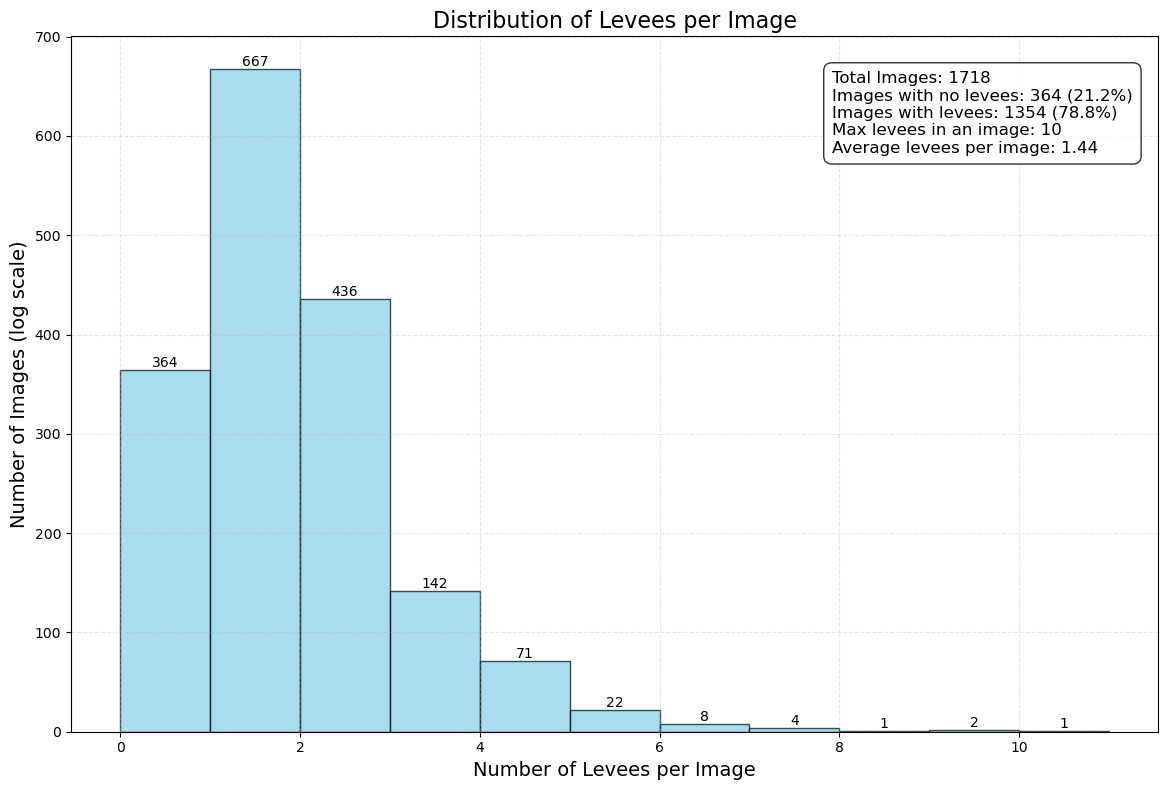

In [5]:
# Create a histogram of the number of levees per image
plt.figure(figsize=(12, 8))

# Get counts for images with no levees and with levees
no_levees = len(results_df[results_df['Levee_Count'] == 0])
with_levees = len(results_df[results_df['Levee_Count'] > 0])

# Create histogram with logarithmic y-scale for better visibility
bins = range(0, results_df['Levee_Count'].max() + 2)
plt.hist(results_df['Levee_Count'], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

# Add datalabel for each bin
for i in range(len(bins)-1):
    count = len(results_df[(results_df['Levee_Count'] >= bins[i]) & (results_df['Levee_Count'] < bins[i+1])])
    plt.text((bins[i] + bins[i+1]) / 2, count, str(count), ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Number of Levees per Image', fontsize=14)
plt.ylabel('Number of Images (log scale)', fontsize=14)
plt.title('Distribution of Levees per Image', fontsize=16)

# Add text annotation with statistics
stats_text = f"Total Images: {len(results_df)}\n" \
          f"Images with no levees: {no_levees} ({no_levees/len(results_df)*100:.1f}%)\n" \
          f"Images with levees: {with_levees} ({with_levees/len(results_df)*100:.1f}%)\n" \
          f"Max levees in an image: {results_df['Levee_Count'].max()}\n" \
          f"Average levees per image: {results_df['Levee_Count'].mean():.2f}"

plt.annotate(stats_text, xy=(0.70, 0.95), xycoords='axes fraction', 
          bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8),
          fontsize=12, ha='left', va='top')

plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Areas of of smaller images from original large 49 TIF files

In [6]:
# US Cities Coordinates
US_Cities = {
   "Los Angeles": (34.0522, -118.2437),
   "Philadelphia": (39.9526, -75.1652),
   "Dallas": (32.7767, -96.7970),
   "Chicago": (41.8781, -87.6298),
   "Houston": (29.7604, -95.3698),
   "Kansas City": (39.0997, -94.5786),
   "Phoenix": (33.4484, -112.0740),
   "San Diego": (32.7157, -117.1611),
   "New York": (40.7128, -74.0060),
   "San Jose": (37.3382, -121.8863),
   "Salt Lake City": (40.7608, -111.8910),
   "Denver": (39.7392, -104.9903),
   "Omaha": (41.2565, -95.9345),
   "Albuquerque": (35.0844, -106.6504),
   "Sacramento": (38.5816, -121.4944),
   "St. Louis": (38.6270, -90.1994),
   "Scranton": (41.4080, -75.6624),
   "Memphis": (35.1495, -90.0490),
   "Seattle": (47.6062, -122.3321),
   "Portland": (45.5051, -122.6750),
   "Orlando": (28.5383, -81.3792),
   "Miami": (25.7617, -80.1918),
   "Fargo": (46.8772, -96.7898),
   "Raleigh(ish)": (35.7796, -78.6382),
   "Indianapolis": (39.7684, -86.1581),
   "Cincinnati": (39.1031, -84.5120)
}

# List of top-left coordinates to search for (26 tiles)
top_left_coords = [(34, -117), (34, -118), (35, -118), (35, -119), # LA
                   (40, -75), (40, -76), (41, -75), (41, -76), #Philadelphia
                   (33, -97), (33, -98), (34, -97), (34, -98), #Dallas
                   (42, -88), (42, -89), (43, -89), #Chicago
                   (30, -96), (31, -95), (31, -96), #Houston
                   (39, -95), (40,-95), (40, -96), # Kansas City
                   (34, -112), (34, -113), #Phoenix
                   (33, -117), (33, -118), # San Diego
                   (41,-74),(42,-74), #NYC
                   (38, -122), (38, -123), # San Jose
                   (41, -112), (41, -113), # Salt Lake City
                   (40, -106), (40, -105), # Denver
                   (42, -97), (42, -96), # Omaha
                   (35, -107), (36, -107), # Albuquerque
                   (39, -122), # Sacramento
                   (39, -91), # St. Louis
                   (42, -76), # Scranton
                   (36, -91), # Memphis
                   (48, -123), # Seattle
                   (46, -123), # Portland
                   (29, -82), # Orlando
                   (27, -81), # Miami
                   (47, -97), # Fargo
                   (36, -78), # Raleigh-ish
                   (40, -87), # Indianapolis
                   (40, -85), # Cincinnati
                   ]

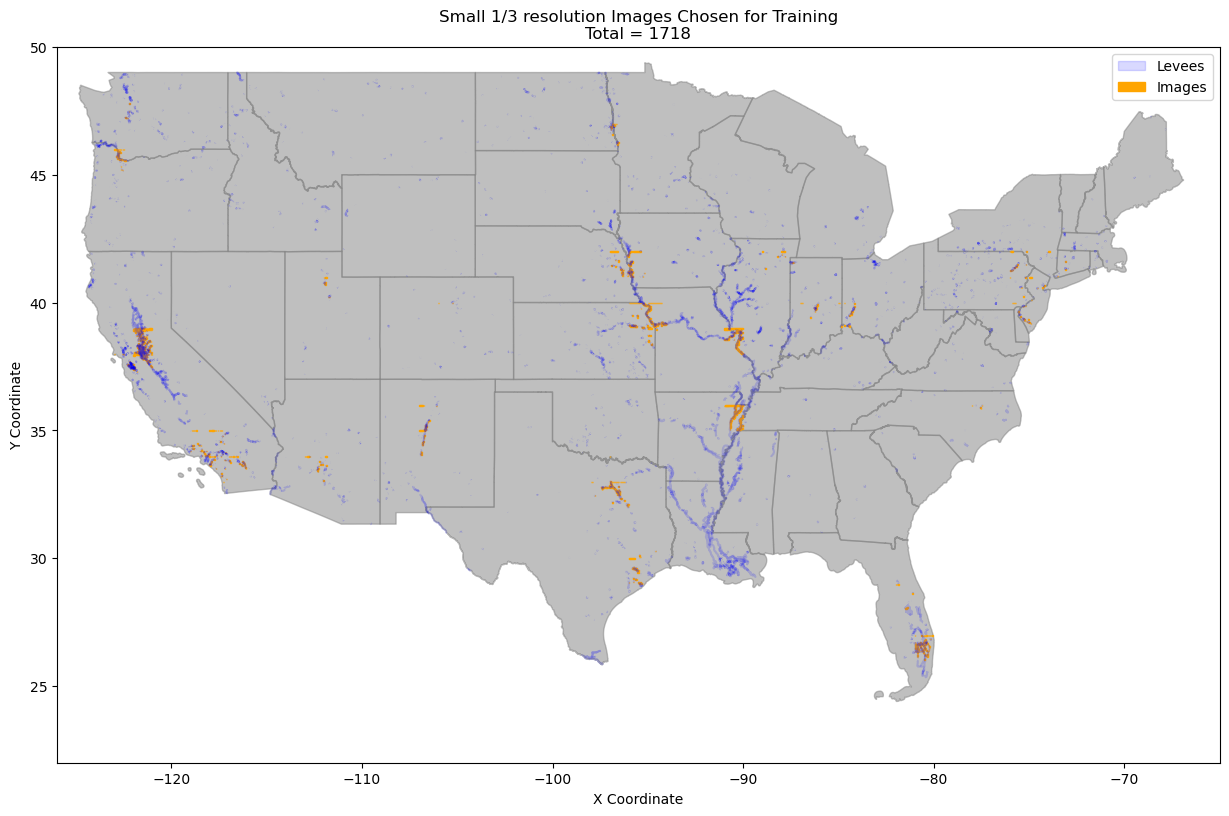

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))

# USA Map
map_gdf.plot(ax=ax, color='grey', alpha=0.5, edgecolor='grey')
levees_gdf.plot(ax=ax, color='blue', alpha=0.15)

# Plot the bounds of each small image
for i, bound in enumerate(small_tif_bounds):
    rect = patches.Rectangle((bound[0], bound[1]), bound[2] - bound[0], bound[3] - bound[1], linewidth=1, edgecolor='orange', facecolor='orange', label=f'Image {i+1}' if i == 0 else "")
    ax.add_patch(rect)

min_lat, max_lat = 22, 50
min_lon, max_lon = -126, -65

# Set axis limits to only contiguous USA
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add legend with markers for levees and images
handles = [
    patches.Patch(color='blue', alpha=0.15, label='Levees'),
    patches.Patch(color='orange', label='Images')
]
plt.legend(handles=handles, loc='upper right')

plt.title(f'Small 1/3 resolution Images Chosen for Training\nTotal = {len(small_tif_bounds)}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [8]:
# Load original size tif data
data_dir = "/share/gpu5/ucapmgb/levee-hunter/data/raw/13_resolution_original"
og_tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]

# Search for tifs with matching top-left coordinates by name
matching_tifs = [f for f in og_tif_files if any(f'n{lat:02d}w{abs(lon):03d}' in f for lat, lon in top_left_coords)]

selected_tifs = [rioxarray.open_rasterio(os.path.join(data_dir, f)) for f in tqdm(matching_tifs)]
bounds_selected = [t.rio.bounds() for t in selected_tifs]

100%|██████████| 49/49 [00:00<00:00, 297.01it/s]


In [9]:
# Extract base filenames from each tif file
pattern = r'USGS_13_(n\d+w\d+)_\d+'
base_filenames = []

for file in tif_files_list:
   match = re.search(pattern, file)
   if match:
      base_filenames.append(match.group(1))

# Count occurrences of each base filename
base_counts = pd.Series(base_filenames).value_counts().reset_index()
base_counts.columns = ['Filename', 'Count']

# Add summary statistics
total_unique = len(base_counts)
total_images = sum(base_counts['Count'])
max_images = base_counts['Count'].max()
avg_images = base_counts['Count'].mean()

print(f"Total unique source files: {total_unique}")
print(f"Total small images: {total_images}")
print(f"Maximum small images from one source: {max_images}")
print(f"Average small images per source: {avg_images:.2f}")

Total unique source files: 44
Total small images: 1718
Maximum small images from one source: 207
Average small images per source: 39.05


In [10]:
# Create a mapping from coordinates to city names
coord_to_city = {}
for city, (lat, lon) in US_Cities.items():
   # Find the closest top-left coordinate to each city
   closest_coord = min(top_left_coords, key=lambda c: abs(c[0] - lat) + abs(c[1] - lon))
   # If multiple cities map to the same coordinate, we'll just keep the last one
   coord_to_city[closest_coord] = city

# Get each base filename from the tif_files_list
pattern = r'USGS_13_(n\d+w\d+)_\d+'
base_to_coords = {}

# Extract the base coordinates from each image filename
for file in tif_files_list:
   match = re.search(pattern, file)
   if match:
      base_name = match.group(1)
      # Extract the coordinates from the base name (e.g., 'n42w097' -> (42, -97))
      lat = int(base_name[1:3])
      lon = -int(base_name[4:7])  # Convert to negative for west longitude
      base_to_coords[base_name] = (lat, lon)

# Count images for each base filename
base_counts = pd.Series(base_filenames).value_counts().reset_index()
base_counts.columns = ['Filename', 'Count']

# Add coordinates and city information to the base_counts dataframe
base_counts['Latitude'] = base_counts['Filename'].apply(lambda x: int(x[1:3]))
base_counts['Longitude'] = base_counts['Filename'].apply(lambda x: -int(x[4:7]))
base_counts['Coordinates'] = base_counts.apply(lambda row: (row['Latitude'], row['Longitude']), axis=1)

# Find the closest city for each coordinate
def find_closest_city(coord):
   # Use the pre-defined mapping if it exists
   for tlc in top_left_coords:
      if abs(tlc[0] - coord[0]) <= 1 and abs(tlc[1] - coord[1]) <= 1:
         if tlc in coord_to_city:
            return coord_to_city[tlc]
   
   # If not found in mapping, find the closest city by distance
   closest_city = min(US_Cities.items(), key=lambda x: abs(x[1][0] - coord[0]) + abs(x[1][1] - coord[1]))
   return closest_city[0]

base_counts['Closest_City'] = base_counts['Coordinates'].apply(find_closest_city)

# Group by city to get summary statistics
city_summary = base_counts.groupby('Closest_City').agg(
   Total_Images=('Count', 'sum'),
   Source_Files=('Filename', 'count'),
   Avg_Images_Per_Source=('Count', 'mean')
).reset_index()

# Sort by total images in descending order
city_summary = city_summary.sort_values('Total_Images', ascending=False)
# Print the summary
print(city_summary)

      Closest_City  Total_Images  Source_Files  Avg_Images_Per_Source
20        San Jose           310             3             103.333333
8      Kansas City           232             3              77.333333
10         Memphis           198             1             198.000000
23       St. Louis           178             1             178.000000
13           Omaha           133             2              66.500000
3           Dallas           122             3              40.666667
9      Los Angeles           104             5              20.800000
11           Miami           104             1             104.000000
6          Houston            56             3              18.666667
0      Albuquerque            47             2              23.500000
17        Portland            41             1              41.000000
15    Philadelphia            40             4              10.000000
5            Fargo            26             1              26.000000
2       Cincinnati  

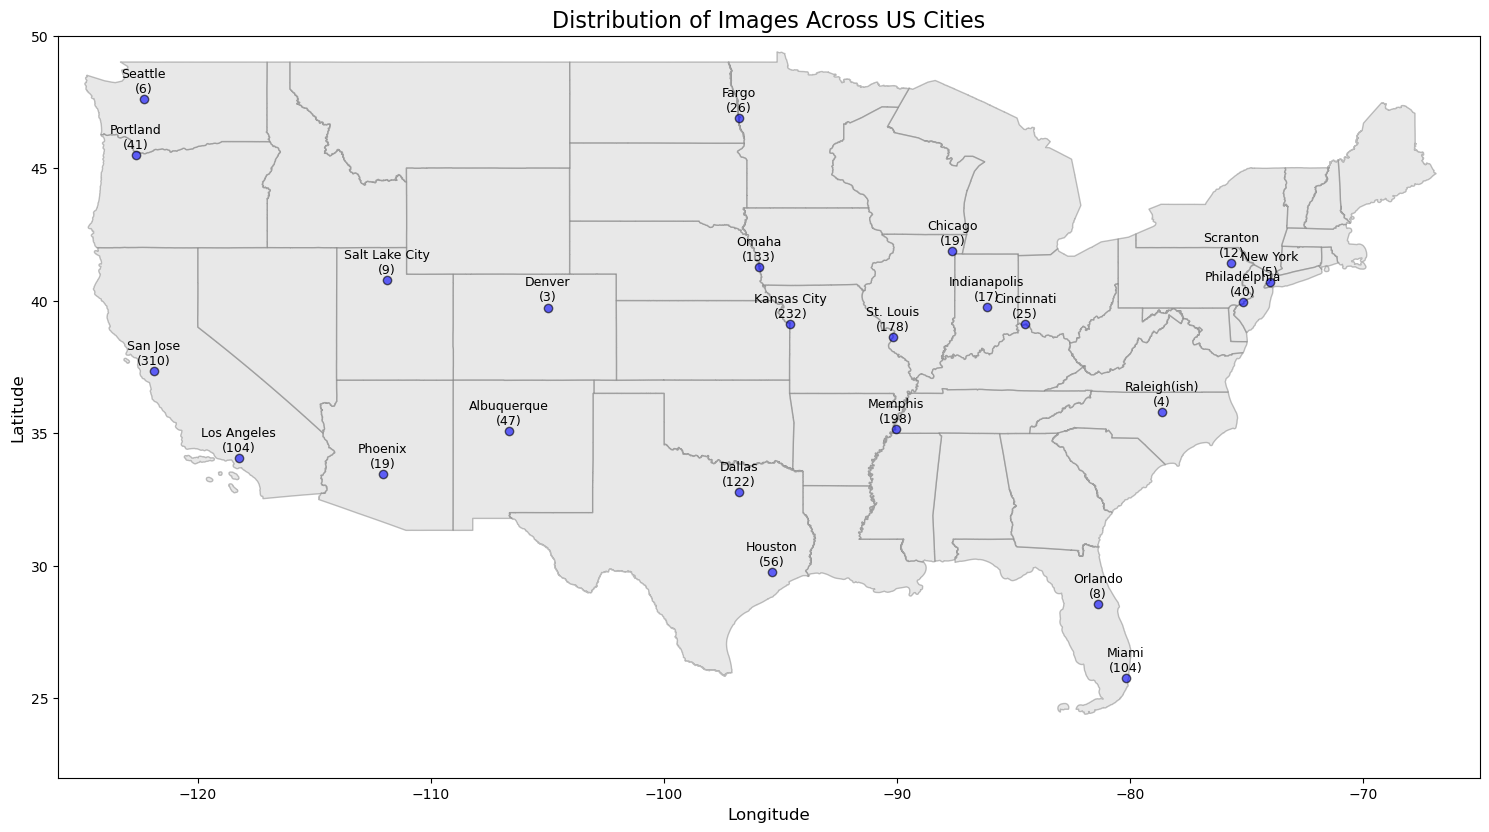

In [11]:
# Create a plot that shows the distribution of images across cities on a US map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot USA Map
map_gdf.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='gray')

# Group by cities to get total image counts
city_counts = city_summary.sort_values('Total_Images', ascending=False)

# Create a scatter plot with city names and bubble sizes based on image count
for i, row in city_counts.iterrows():
   city_name = row['Closest_City']
   if city_name in US_Cities:
      lat, lon = US_Cities[city_name]
      img_count = row['Total_Images']
      ax.scatter(lon, lat, c='blue', alpha=0.6, edgecolor='black')
      
      # Annotate with city name and image count
      ax.annotate(f"{city_name}\n({img_count})", 
               (lon, lat), 
               textcoords="offset points",
               xytext=(0,5), 
               ha='center', 
               fontsize=9)

# Set axis limits to only contiguous USA
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add legend and titles
plt.title('Distribution of Images Across US Cities', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

plt.tight_layout()
plt.show()

### Stats still to do
- Rural vs Urban
- Population density vs images